In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import tensorflow as tf

In [2]:
from tf_ann_model.processing.data_management import load_dataset
train = load_dataset(file_name='AWID-CLS-R-Trn.csv')
test = load_dataset(file_name='AWID-CLS-R-Tst.csv')

C:\Users\skyst\Anaconda3\envs\tf\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\skyst\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (82,86,87,103,104,105,108,109,111,113,114,124,139,141,142,143,147) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\skyst\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (103,104,105,108,109,111,113,114,124,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (aw

In [3]:
from tf_ann_model.processing.data_management import prepare_data

X_train, y_train = prepare_data(train, True)
X_test, y_test = prepare_data(test, False)

In [4]:
from tf_ann_model.processing.feat_eng_categ import categ_missing_encoder, rare_label_encoder, label_encoder, one_hot_encoder
from tf_ann_model.processing.feat_eng_num import outlier_capping, ArbitraryNumberImputer
from tf_ann_model.processing.feat_creation import feature_creation
from tf_ann_model.processing.feat_selection import remove_constant, remove_quasi_constant, selected_drop_features, remove_correlated_features
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

fe_pipe = Pipeline([
                ('oc', outlier_capping(distribution='quantiles')),
                ('cme2', categ_missing_encoder()),
                ('rle', rare_label_encoder(0.0001)),                
                ('ani', ArbitraryNumberImputer()),
                ('le', label_encoder()),
                ('sd', selected_drop_features()),
                ('rc', remove_constant()),
                ('rqc', remove_quasi_constant()),
                ('rcf', remove_correlated_features()),
                ('scaler', StandardScaler())
            ])

In [5]:
X_train = fe_pipe.fit_transform(X_train)
X_test = fe_pipe.transform(X_test)

In [6]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import models, layers
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose = 0 )
styles = [':', '-.', '--', '-', ':', '-.', '--', '-', ':', '-.', '--', '-' ]

In [7]:
nets = 7
model = [0]* nets

for j in range(nets):
    model[j] = models.Sequential()
    model[j].add( layers.Dense( 2**(j+4), activation = 'relu', input_shape=(X_train.shape[1],) ) )
    model[j].add( layers.Dense(4, activation='softmax'))
    model[j].compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [8]:
history = [0] * nets
epochs = 25

names = []
for j in range(nets):
    names.append( str(2**(j+4)) + ' Nodes' )

for j in range(nets):
    history[j] = model[j].fit(X_train, y_train, batch_size=1000, epochs=epochs,
                             validation_data = (X_test, y_test), callbacks = [annealer],
                             verbose=0)
    print( "ANN {0}: Epochs={1:d}, Train Accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
    names[j], epochs, max(history[j].history['accuracy']), max(history[j].history['val_accuracy']) ))



ANN 16 Nodes: Epochs=25, Train Accuracy=0.99854, Validation accuracy=0.63515
ANN 32 Nodes: Epochs=25, Train Accuracy=0.99929, Validation accuracy=0.87945
ANN 64 Nodes: Epochs=25, Train Accuracy=0.99958, Validation accuracy=0.88089
ANN 128 Nodes: Epochs=25, Train Accuracy=0.99972, Validation accuracy=0.86514
ANN 256 Nodes: Epochs=25, Train Accuracy=0.99978, Validation accuracy=0.57066
ANN 512 Nodes: Epochs=25, Train Accuracy=0.99985, Validation accuracy=0.88072
ANN 1024 Nodes: Epochs=25, Train Accuracy=0.99991, Validation accuracy=0.87511


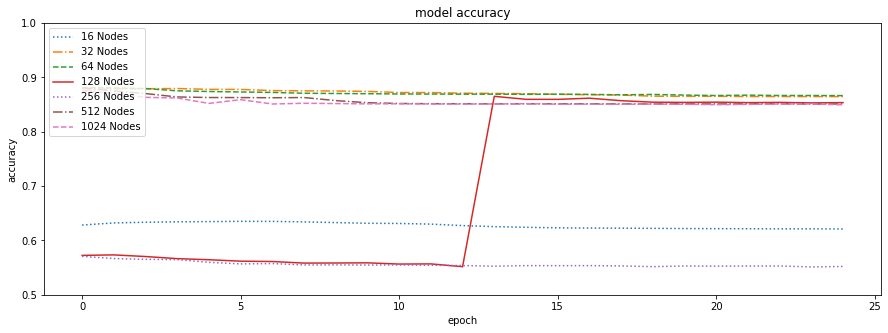

In [9]:
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot( history[i].history['val_accuracy'], linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.5,1])
plt.show()

In [10]:
nets = 5
model = [0]* nets

for j in range(nets):
    model[j] = models.Sequential()
    model[j].add( layers.Dense(32, activation = 'relu', input_shape=(X_train.shape[1],)))
    model[j].add( layers.Dense(2**(j+6), activation = 'relu'))
    model[j].add( layers.Dense(4, activation='softmax'))
    model[j].compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = [0] * nets
epochs = 25

names = []
for j in range(nets):
    names.append( str(2**(j+4)) + ' Nodes' )

for j in range(nets):
    history[j] = model[j].fit(X_train, y_train, batch_size=1000, epochs=epochs,
                             validation_data = (X_test, y_test), callbacks = [annealer],
                             verbose=0)
    print( "ANN {0}: Epochs={1:d}, Train Accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
    names[j], epochs, max(history[j].history['accuracy']), max(history[j].history['val_accuracy']) ))

ANN 16 Nodes: Epochs=25, Train Accuracy=0.99993, Validation accuracy=0.86233
ANN 32 Nodes: Epochs=25, Train Accuracy=0.99993, Validation accuracy=0.87178
ANN 64 Nodes: Epochs=25, Train Accuracy=0.99994, Validation accuracy=0.85673
ANN 128 Nodes: Epochs=25, Train Accuracy=0.99994, Validation accuracy=0.87527
ANN 256 Nodes: Epochs=25, Train Accuracy=0.99993, Validation accuracy=0.84978


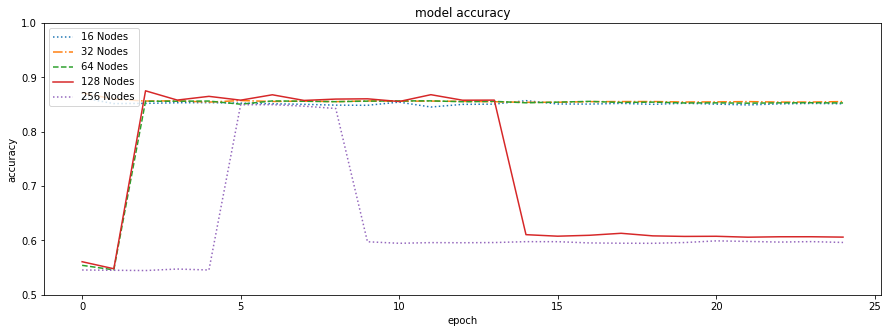

In [12]:
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot( history[i].history['val_accuracy'], linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.5,1])
plt.show()

In [13]:

nets = 5
model = [0]* nets

for j in range(nets):
    model[j] = models.Sequential()
    model[j].add( layers.Dense(64, activation = 'relu', input_shape=(X_train.shape[1],)))
    model[j].add( layers.Dense(2**(j+6), activation = 'relu'))
    model[j].add( layers.Dense(4, activation='softmax'))
    model[j].compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:

history = [0] * nets
epochs = 25

names = []
for j in range(nets):
    names.append( str(2**(j+4)) + ' Nodes' )

for j in range(nets):
    history[j] = model[j].fit(X_train, y_train, batch_size=1000, epochs=epochs,
                             validation_data = (X_test, y_test), callbacks = [annealer],
                             verbose=0)
    print( "ANN {0}: Epochs={1:d}, Train Accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
    names[j], epochs, max(history[j].history['accuracy']), max(history[j].history['val_accuracy']) ))

ANN 16 Nodes: Epochs=100, Train Accuracy=0.99995, Validation accuracy=0.85623
ANN 32 Nodes: Epochs=100, Train Accuracy=0.99995, Validation accuracy=0.86961
ANN 64 Nodes: Epochs=100, Train Accuracy=0.99995, Validation accuracy=0.86889
ANN 128 Nodes: Epochs=100, Train Accuracy=0.99995, Validation accuracy=0.85511
ANN 256 Nodes: Epochs=100, Train Accuracy=0.99995, Validation accuracy=0.86491


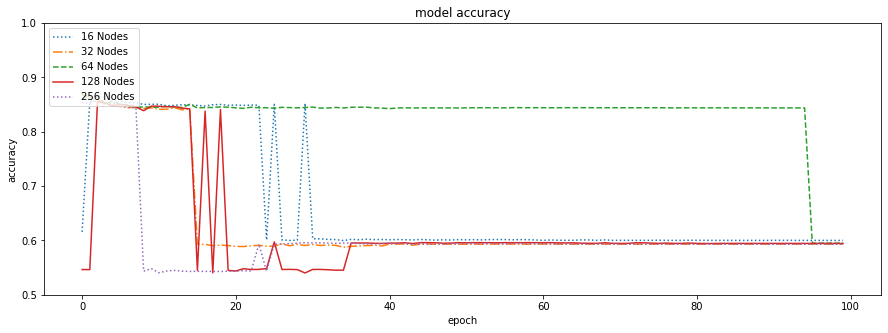

In [15]:
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot( history[i].history['val_accuracy'], linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.5,1])
plt.show()

In [ ]:
import tf_ann_model.model as m
model = m.ann_model(input_shape=(X_train.shape[1],))
model.summary()